In [2]:
from google.colab import files

In [3]:
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [4]:
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [5]:
!kaggle datasets download -d puneet6060/intel-image-classification

intel-image-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
!unzip intel-image-classification.zip

Streaming output truncated to the last 5000 lines.
  inflating: seg_train/seg_train/mountain/7506.jpg  
  inflating: seg_train/seg_train/mountain/7537.jpg  
  inflating: seg_train/seg_train/mountain/7539.jpg  
  inflating: seg_train/seg_train/mountain/7551.jpg  
  inflating: seg_train/seg_train/mountain/7560.jpg  
  inflating: seg_train/seg_train/mountain/7565.jpg  
  inflating: seg_train/seg_train/mountain/7578.jpg  
  inflating: seg_train/seg_train/mountain/7581.jpg  
  inflating: seg_train/seg_train/mountain/7586.jpg  
  inflating: seg_train/seg_train/mountain/7647.jpg  
  inflating: seg_train/seg_train/mountain/7652.jpg  
  inflating: seg_train/seg_train/mountain/7654.jpg  
  inflating: seg_train/seg_train/mountain/7662.jpg  
  inflating: seg_train/seg_train/mountain/767.jpg  
  inflating: seg_train/seg_train/mountain/7672.jpg  
  inflating: seg_train/seg_train/mountain/7679.jpg  
  inflating: seg_train/seg_train/mountain/7681.jpg  
  inflating: seg_train/seg_train/mountain/7693.jp

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle
import cv2
import tensorflow as tf
from tqdm import tqdm

In [8]:
class_names = ['mountain', 'street', 'glacier', 'buildings', 'sea', 'forest']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

print("class_names_label", class_names_label)
print("nb_classes", nb_classes)

IMAGE_SIZE = (150, 150)

class_names_label {'mountain': 0, 'street': 1, 'glacier': 2, 'buildings': 3, 'sea': 4, 'forest': 5}
nb_classes 6


In [9]:
def load_data():
    """
        Load the data:
            - 14,034 images to train the network.
            - 3,000 images to evaluate how accurately the network learned to classify images.
    """

    datasets = ['/content/seg_train/seg_train', '/content/seg_test/seg_test']
    output = []

    # Iterate through training and test sets
    for dataset in datasets:

        images = []
        labels = []

        print("Loading {}".format(dataset))

        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]

            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):

                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)

                # Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE)

                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)

        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')

        output.append((images, labels))

    return output

In [10]:
(train_images, train_labels), (test_images, test_labels) = load_data()

Loading /content/seg_train/seg_train


100%|██████████| 2512/2512 [00:01<00:00, 1975.98it/s]


Loading /content/seg_test/seg_test


100%|██████████| 525/525 [00:00<00:00, 1260.95it/s]


In [11]:
n_train = train_labels.shape[0]
n_test = test_labels.shape[0]

print ("Number of training examples: {}".format(n_train))
print ("Number of testing examples: {}".format(n_test))
print ("Each image is of size: {}".format(IMAGE_SIZE))

print(train_labels.shape)
print(test_labels.shape)

Number of training examples: 14034
Number of testing examples: 3000
Each image is of size: (150, 150)
(14034,)
(3000,)


In [12]:
train_images = train_images / 255.0
test_images = test_images / 255.0

In [13]:
def display_random_image(class_names, images, labels):
    """
        Display a random image from the images array and its correspond label from the labels array.
    """

    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{} : '.format(index) + class_names[labels[index]])
    plt.show()

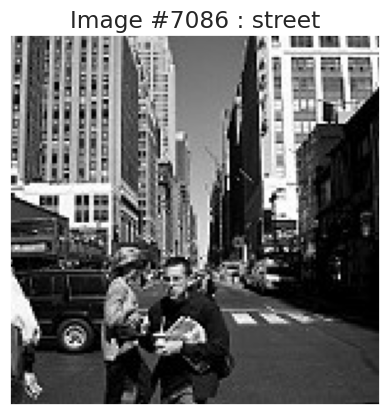

In [14]:
display_random_image(class_names, train_images, train_labels)

**Image augmentation:**

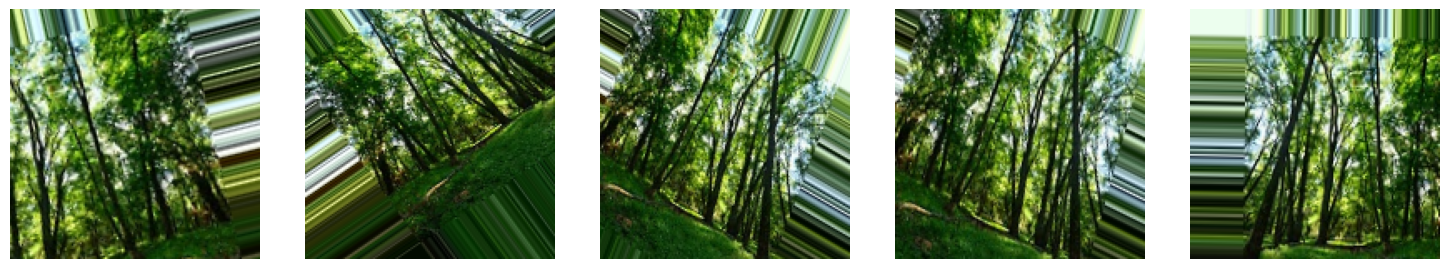

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define augmentation parameters in a dictionary
augmentation_params = {
    'rotation_range': 40,
    'width_shift_range': 0.2,
    'height_shift_range': 0.2,
    'shear_range': 0.2,
    'zoom_range': 0.2,
    'horizontal_flip': True,
    'fill_mode': 'nearest'
}

# Initialize ImageDataGenerator with the parameters
data_generator = ImageDataGenerator(**augmentation_params)

# Prepare the example image for augmentation
example_img = train_images[0].reshape((1,) + train_images[0].shape)  # Reshape to (1, height, width, channels)

# Plotting setup
fig = plt.figure(figsize=(15, 3))

# Check if the images are normalized (i.e., pixel values are in [0, 1])
normalized = np.max(train_images[0]) <= 1.0

# Generate and display augmented images
for idx, aug_img in zip(range(5), data_generator.flow(example_img, batch_size=1)):
    plt.subplot(1, 5, idx + 1)
    if normalized:
        plt.imshow(np.clip(aug_img[0] * 255, 0, 255).astype('uint8'))  # Scale back to [0, 255] and convert to uint8
    else:
        plt.imshow(aug_img[0].astype('uint8'))
    plt.axis('off')

plt.tight_layout()
plt.show()

Two ImageDataGenerator instances from TensorFlow's Keras API, one with augmentation parameters for training and another without augmentation for validation.

In [16]:
# Define a function to create an ImageDataGenerator
def create_datagen(rotation=0, width_shift=0, height_shift=0, shear=0, zoom=0, flip_horizontal=False, fill='nearest'):
    return ImageDataGenerator(
        rotation_range=rotation,
        width_shift_range=width_shift,
        height_shift_range=height_shift,
        shear_range=shear,
        zoom_range=zoom,
        horizontal_flip=flip_horizontal,
        fill_mode=fill
    )

# Create ImageDataGenerator instances for training and validation
train_datagen = create_datagen(40, 0.2, 0.2, 0.2, 0.2, True, 'nearest')
val_datagen = create_datagen()

In [17]:
# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model.h5', save_best_only=True)

Defining a convolutional neural network (CNN) using TensorFlow's Keras API, which includes several convolutional layers, batch normalization, max pooling, flattening, and dense layers:

In [18]:
# Initialize a Sequential model
model = tf.keras.Sequential()

# Define the filter sizes for each Conv2D layer
filter_sizes = [32, 64, 128, 256, 512]

# Iterate over the filter sizes to add Conv2D, BatchNormalization, and MaxPooling2D layers
for idx, size in enumerate(filter_sizes):
    # Add the Conv2D layer
    if idx == 0:
        # Specify the input_shape for the first layer
        model.add(tf.keras.layers.Conv2D(size, (3, 3), activation='relu', input_shape=(150, 150, 3)))
    else:
        # For other layers, do not specify the input_shape
        model.add(tf.keras.layers.Conv2D(size, (3, 3), activation='relu'))

    # Add the BatchNormalization and MaxPooling2D layers
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D(2, 2))

# Add the Flatten layer
model.add(tf.keras.layers.Flatten())

# Add the Dense layers
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))

# Add the Output layer
model.add(tf.keras.layers.Dense(6, activation='softmax'))

# Display the model's architecture
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 148, 148, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 72, 72, 64)        256       
 chNormalization)                                                
                                                        

Setting up and verifying the availability and usage of NVIDIA GPUs for deep learning tasks, specifically with TensorFlow's GPU support.

In [19]:
!nvidia-smi

Mon Dec  4 01:11:31 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    26W /  70W |    339MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [20]:
pip install tensorflow-gpu

  Using cached tensorflow-gpu-2.12.0.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [21]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [22]:
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2.14.0
Num GPUs Available:  1


<p>
Compile the Model:
</p>
Adam is an optimization algorithm that can be used instead of the classical stochastic gradient descent procedure to update network weights iteratively based on training data. It's a popular choice due to its efficiency in handling sparse gradients and adaptive learning rates.

In [23]:
from tensorflow.keras.optimizers import Adam

# Compile the model with an explicit instance of the Adam optimizer
model.compile(optimizer=Adam(learning_rate=0.001),  # Default learning rate for Adam
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model with data augmentation for training data and without augmentation for validation data
history = model.fit(
    train_datagen.flow(train_images, train_labels, batch_size=32),
    steps_per_epoch=len(train_images) // 32,
    epochs=20,
    validation_data=val_datagen.flow(test_images, test_labels, batch_size=32),
    validation_steps=len(test_images) // 32,
    callbacks=[early_stopping, model_checkpoint]
)


Epoch 1/20
438/438 [==============================] - 113s 203ms/step - loss: 1.4402 - accuracy: 0.4862 - val_loss: 1.9790 - val_accuracy: 0.3629
Epoch 2/20


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


438/438 [==============================] - 89s 202ms/step - loss: 1.1064 - accuracy: 0.5851 - val_loss: 0.7789 - val_accuracy: 0.7124
Epoch 3/20
438/438 [==============================] - 87s 199ms/step - loss: 1.0096 - accuracy: 0.6236 - val_loss: 0.9834 - val_accuracy: 0.6465
Epoch 4/20
438/438 [==============================] - 87s 199ms/step - loss: 0.9474 - accuracy: 0.6581 - val_loss: 0.8028 - val_accuracy: 0.7144
Epoch 5/20
438/438 [==============================] - 86s 197ms/step - loss: 0.8741 - accuracy: 0.6874 - val_loss: 0.6766 - val_accuracy: 0.7634
Epoch 6/20
438/438 [==============================] - 86s 197ms/step - loss: 0.8402 - accuracy: 0.6987 - val_loss: 0.9271 - val_accuracy: 0.6539
Epoch 7/20
438/438 [==============================] - 86s 197ms/step - loss: 0.8043 - accuracy: 0.7162 - val_loss: 2.3788 - val_accuracy: 0.4580
Epoch 8/20
438/438 [==============================] - 86s 196ms/step - loss: 0.7779 - accuracy: 0.7232 - val_loss: 1.1846 - val_accuracy: 0.6

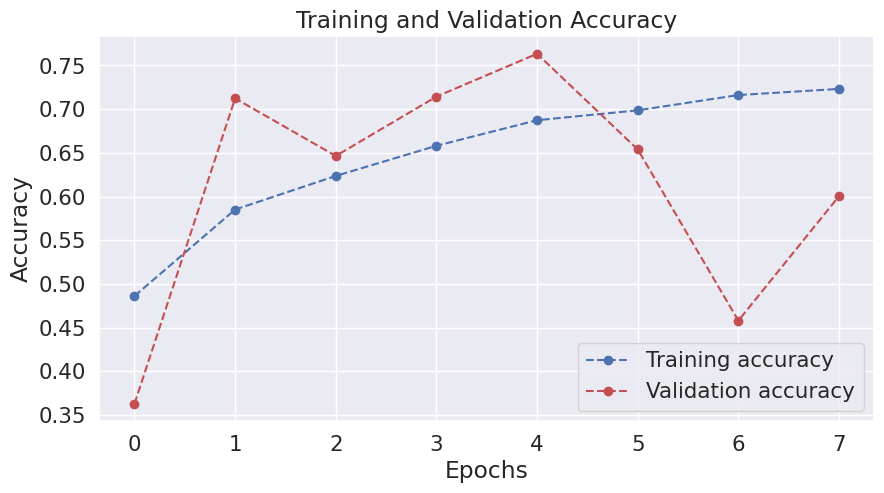

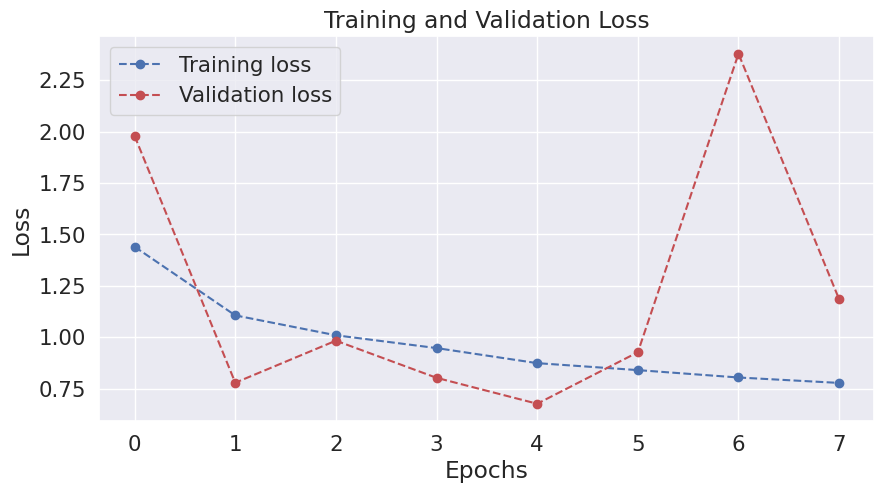

In [24]:
def plot_accuracy_loss(history):
    """
    Plot the accuracy and the loss during the training of the neural network separately.
    """
    # Plotting Accuracy
    fig1, ax1 = plt.subplots(figsize=(10, 5))
    ax1.plot(history.history['accuracy'], 'bo--', label="Training accuracy")
    ax1.plot(history.history['val_accuracy'], 'ro--', label="Validation accuracy")
    ax1.set_title("Training and Validation Accuracy")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Accuracy")
    ax1.legend()
    ax1.grid(True)

    # Plotting Loss
    fig2, ax2 = plt.subplots(figsize=(10, 5))
    ax2.plot(history.history['loss'], 'bo--', label="Training loss")
    ax2.plot(history.history['val_loss'], 'ro--', label="Validation loss")
    ax2.set_title("Training and Validation Loss")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Loss")
    ax2.legend()
    ax2.grid(True)

    plt.show()

# Call the function with the training history
plot_accuracy_loss(history)


In [25]:
# Retrieve the training accuracy from the last epoch
final_train_accuracy = history.history['accuracy'][-1]

# Print the training accuracy
print(f"Final Training Accuracy: {final_train_accuracy * 100:.2f}%")


Final Training Accuracy: 72.32%


**TEST SET**

94/94 - 1s - loss: 0.6776 - accuracy: 0.7630 - 1s/epoch - 15ms/step

Test Accuracy: 76.30%
94/94 [==============================] - 1s 12ms/step


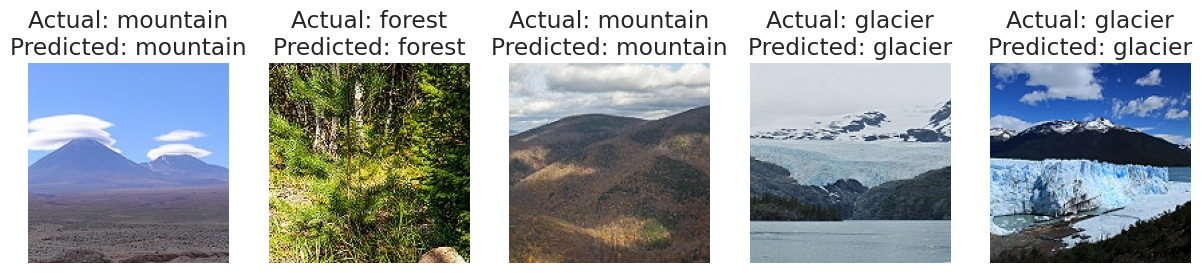

In [26]:
def display_random_images(images, actual_labels, predicted_labels, class_names, num_images=5):
    """
    Display random images from the dataset with actual and predicted labels.

    Parameters:
    images (array): The array of images.
    actual_labels (array): The actual labels of the images.
    predicted_labels (array): The predicted labels of the images.
    class_names (list): The list of class names corresponding to the labels.
    num_images (int): Number of images to display.
    """
    indices = np.random.choice(len(images), num_images, replace=False)

    plt.figure(figsize=(15, 5))
    for i, index in enumerate(indices):
        plt.subplot(1, num_images, i+1)
        plt.imshow(images[index])
        plt.title(f"Actual: {class_names[actual_labels[index]]}\nPredicted: {class_names[predicted_labels[index]]}")
        plt.axis('off')
    plt.show()

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_images, test_labels, verbose=2)
print(f"\nTest Accuracy: {test_accuracy * 100:.2f}%")

# Make predictions on the test set
predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

# Display random images with their actual and predicted labels
display_random_images(test_images, test_labels, predicted_labels, class_names)


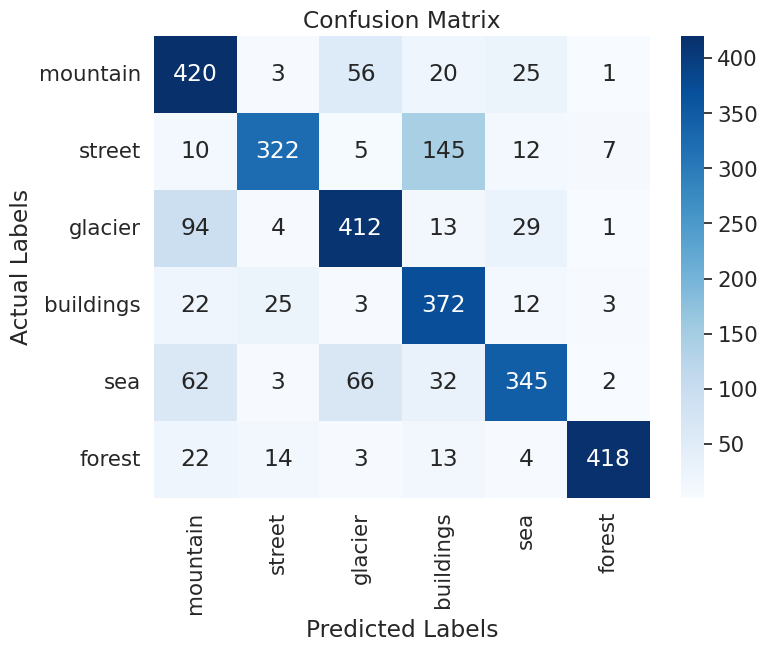

In [27]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generate the confusion matrix
conf_matrix = confusion_matrix(test_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.show()

In [28]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_images, test_labels, verbose=2)

# Print the final test accuracy
print(f"Final Test Accuracy: {test_accuracy * 100:.2f}%")


94/94 - 1s - loss: 0.6776 - accuracy: 0.7630 - 1s/epoch - 13ms/step
Final Test Accuracy: 76.30%


**Pretrained Model**

In [29]:
# Load the pre-trained InceptionV3 model without the top layers
base_model = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(150, 150, 3))


In [30]:
# Freeze the first few layers
num_layers_to_freeze = 30
for layer in base_model.layers[:num_layers_to_freeze]:
    layer.trainable = False

In [31]:
from tensorflow.keras import models, layers
# Function to add custom layers on top of the base model
def add_custom_layers(base_model, num_classes):
    model = models.Sequential([
        base_model,
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

In [32]:
# Create a new model
model = add_custom_layers(base_model, nb_classes)

In [33]:
# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [34]:
# Data augmentation for training data
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# No augmentation for validation data
val_datagen = ImageDataGenerator()

In [35]:
# Callbacks definition
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model_vgg16.h5', save_best_only=True)

In [36]:
# Train the model
history = model.fit(
    train_datagen.flow(train_images, train_labels, batch_size=32),
    steps_per_epoch=len(train_images) // 32,
    epochs=10,
    validation_data=val_datagen.flow(test_images, test_labels, batch_size=32),
    validation_steps=len(test_images) // 32,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/10
438/438 [==============================] - ETA: 0s - loss: 1.1890 - accuracy: 0.5683

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


438/438 [==============================] - 137s 235ms/step - loss: 1.1890 - accuracy: 0.5683 - val_loss: 0.8891 - val_accuracy: 0.7261
Epoch 2/10
438/438 [==============================] - 99s 227ms/step - loss: 0.7376 - accuracy: 0.7648 - val_loss: 0.8976 - val_accuracy: 0.6690
Epoch 3/10
438/438 [==============================] - 100s 227ms/step - loss: 0.6332 - accuracy: 0.7984 - val_loss: 5.1571 - val_accuracy: 0.3377
Epoch 4/10
438/438 [==============================] - 105s 239ms/step - loss: 0.6132 - accuracy: 0.8042 - val_loss: 0.4797 - val_accuracy: 0.8306
Epoch 5/10
438/438 [==============================] - 97s 221ms/step - loss: 0.5797 - accuracy: 0.8106 - val_loss: 2.8168 - val_accuracy: 0.6250
Epoch 6/10
438/438 [==============================] - 97s 222ms/step - loss: 0.5829 - accuracy: 0.8112 - val_loss: 644.5602 - val_accuracy: 0.3774
Epoch 7/10
438/438 [==============================] - 104s 237ms/step - loss: 0.7446 - accuracy: 0.7569 - val_loss: 0.4777 - val_accurac

In [37]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_images, test_labels, verbose=2)
print(f"\nTest Accuracy: {test_accuracy * 100:.2f}%")

94/94 - 4s - loss: 0.3729 - accuracy: 0.8780 - 4s/epoch - 40ms/step

Test Accuracy: 87.80%


In [38]:
# Make predictions
predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

94/94 [==============================] - 5s 31ms/step


In [39]:
# Function to display random images with actual and predicted labels
def display_random_images(images, actual_labels, predicted_labels, class_names, num_images=5):
    indices = np.random.choice(len(images), num_images, replace=False)
    plt.figure(figsize=(15, 5))
    for i, index in enumerate(indices, 1):
        plt.subplot(1, num_images, i)
        plt.imshow(images[index])
        plt.title(f"Actual: {class_names[actual_labels[index]]}\nPredicted: {class_names[predicted_labels[index]]}")
        plt.axis('off')
    plt.show()

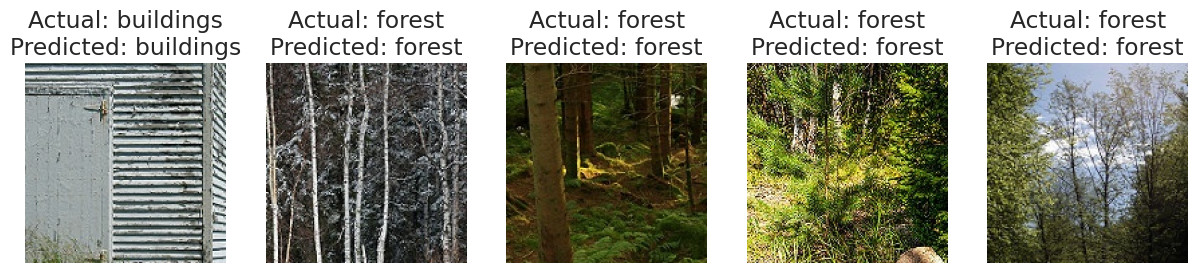

In [40]:
# Display images
display_random_images(test_images, test_labels, predicted_labels, class_names)

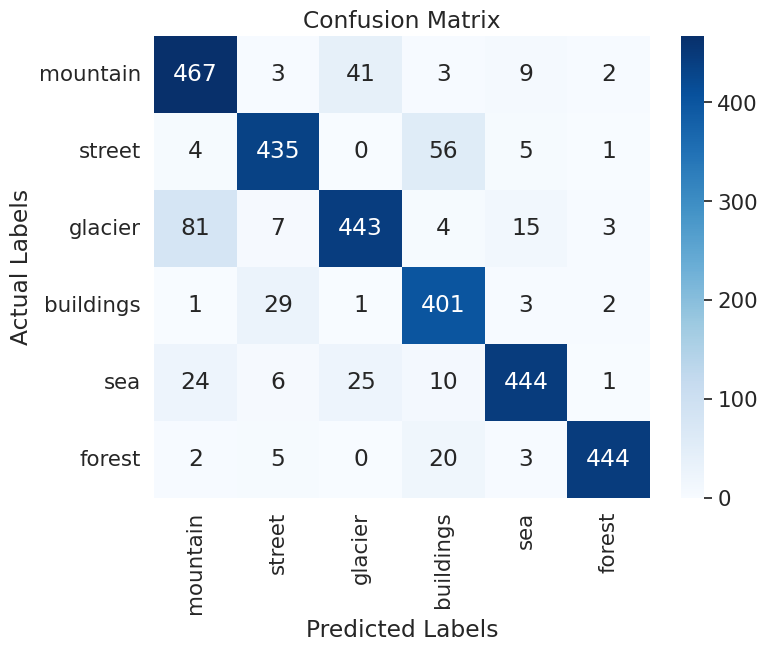

In [41]:
# Function to plot confusion matrix
def plot_confusion_matrix(actual_labels, predicted_labels, class_names):
    conf_matrix = confusion_matrix(actual_labels, predicted_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('Actual Labels')
    plt.show()

# Plot confusion matrix
plot_confusion_matrix(test_labels, predicted_labels, class_names)